In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
from Libraries_functions import *
from tqdm import tqdm
import glob

In [3]:
def select_spectrograms(spectrograms,
                        file_paths,
                        min_max_values,
                        num_spectrograms=4):
    num_spec_each_class = int(num_spectrograms / 4)
    num_spec_each_class_rest = num_spec_each_class+ (num_spectrograms-num_spec_each_class*4)
    sampled_indexes_0 = np.random.choice(range(0,int(len(spectrograms)/4)-1), num_spec_each_class)
    sampled_indexes_1 = np.random.choice(range(int(len(spectrograms)/4),(int(len(spectrograms)/4)*2)-1), num_spec_each_class)
    sampled_indexes_2 = np.random.choice(range((int(len(spectrograms)/4)*2),(int(len(spectrograms)/4)*3)-1), num_spec_each_class_rest)
    sampled_indexes_3 = np.random.choice(range((int(len(spectrograms)/4)*3),(int(len(spectrograms)/4)*4)-1), num_spec_each_class)
    sampled_indexes=np.concatenate((sampled_indexes_0,sampled_indexes_1,sampled_indexes_2,sampled_indexes_3))
    sampled_spectrogrmas = spectrograms[sampled_indexes]
    file_paths = [file_paths[index] for index in sampled_indexes]
    # file_paths=[i for i in sorted(file_paths, key=lambda x: (int(x.split("d")[-1].split(".")[0])))]
    sampled_min_max_values = [min_max_values[file_path] for file_path in
                           file_paths]
    print(file_paths)
    return sampled_spectrogrmas, sampled_min_max_values, file_paths

def load_form_direc(dir_path):
    train=[]
    file_paths=[]
    for root, _, filenames in os.walk(dir_path):
        for file_name in sorted(filenames, key=lambda x: (int(x.split("d")[-1].split(".")[0]))): #TODO: mirar por que no se guardan en orden
            filepath= os.path.join(root, file_name)
            spectrogram=np.load(filepath)
            train.append(spectrogram)
            file_paths.append(filepath)
        train=np.array(train)
        train = train[..., np.newaxis]

    return train, file_paths

def load_min_max(min_max_path):
    with open (min_max_path, "rb") as f:
        min_max_values = pickle.load(f)
    return min_max_values

def save_signals(signals, save_dir,voice_paths,type, sample_rate=22050):
    py_files_m = glob.glob(f'{save_dir}*')
    for py_file in py_files_m:
        try:
            os.remove(py_file)
        except OSError as e:
            print(f"Error:{ e.strerror}")
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, type+voice_paths[i] + ".wav")
        sf.write(save_path, signal, sample_rate)

def preprocess_files():
    ## Ejecutar solo si no tenemos los tests generados correctamente

    py_files_m = glob.glob(f'{SPECTROGRAMS_SAVE_DIR}*')
    for py_file in py_files_m:
        try:
            os.remove(py_file)
        except OSError as e:
            print(f"Error:{ e.strerror}")

    py_files_m = glob.glob(f'{MIN_MAX_VALUES_SAVE_DIR}*')
    for py_file in py_files_m:
        try:
            os.remove(py_file) 
        except OSError as e:
            print(f"Error:{ e.strerror}")


    # instantiate all objects
    loader = Loader(SAMPLE_RATE, DURATION,MONO)
    padder = Padder()
    log_spectrogram_extractor = LogSpectrogramExtractor(N_FFT, HOP_LENGTH)
    min_max_normaliser = MinMaxNormaliser(0, 1)
    saver= Saver(SPECTROGRAMS_SAVE_DIR,MIN_MAX_VALUES_SAVE_DIR)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = log_spectrogram_extractor
    preprocessing_pipeline.normaliser = min_max_normaliser
    preprocessing_pipeline.saver = saver

    preprocessing_pipeline.process(FILES_DIR)

def convert_spectrograms_to_audio(spectrograms, min_max_values, noise, files_path):
    _min_max_normaliser=MinMaxNormaliser(0, 1)
    signals = []
    path_signals=[]
    contador=0
    for spectrogram, min_max_value, files_path in zip(spectrograms, min_max_values, files_path):
        # reshape the log spectrogram
        log_spectrogram = spectrogram[:, :, 0]
        # apply denormalisation
        denorm_log_spec = _min_max_normaliser.denormalise(
            log_spectrogram, min_max_value["min"], min_max_value["max"])
        if(contador<4):
            librosa.display.specshow(denorm_log_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)## Nos permite visualizar como un mapa de calor
            name="mixed"if noise else "predicted"
            plt.title(f"{name}_Name:{files_path}")
            plt.xlabel("Time")
            plt.ylabel("Frequency")
            plt.colorbar()
            plt.show()
            contador+=1
            # log spectrogram -> spectrogram
        spec = librosa.db_to_amplitude(denorm_log_spec)
        # apply Griffin-Lim
        _, phase= librosa.magphase(spec)
        #signal = librosa.istft(spec*phase, hop_length=self.hop_length)
        signal = librosa.istft(spec*min_max_value["mag_phase"], hop_length=HOP_LENGTH)

        # append signal to "signals"
        signals.append(signal)
        path_signals.append(files_path)
    return signals, path_signals

def spectrograms_of_voice(file_path):
    signals = []
    path_signals=[]
    contador=0
    for spectrogram in (file_path):
        signal_noise, sr_noise = librosa.load(spectrogram, sr=SAMPLE_RATE, mono=True)

        stft_mixed= librosa.stft(signal_noise, n_fft=N_FFT, hop_length=HOP_LENGTH)[:-1]
        spectrogram_mixed= np.abs(stft_mixed)
        log_spectrogram_mixed= librosa.amplitude_to_db(spectrogram_mixed)
        if(contador<4):
            librosa.display.specshow(log_spectrogram_mixed, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)## Nos permite visualizar como un mapa de calor
            plt.title(f"voice_{spectrogram}")
            plt.xlabel("Time")
            plt.ylabel("Frequency")
            plt.colorbar()
            plt.show()
            contador+=1
        # append signal to "signals"
        signals.append(signal_noise)
        path_signals.append(spectrogram)
    return signals, path_signals

def search_voices(file_path):
    def know_number_spec(file_path):
        paths=[]
        for file in file_path:
            file_cut=file.split("d")[-1].split(".")[0]
            paths.append(file_cut)
        return paths

    def find_noise(mixed_numbers):
        voice_paths=[]
        py_files_m = glob.glob(f'{PATH_TO_VOICES}*')
        for py_file in py_files_m:
            file=(py_file.split("e")[-1].split(".")[0])
            if(file in mixed_numbers):
                voice_paths.append(py_file)
        voice_paths=[i for i in sorted(voice_paths, key=lambda x: (int(x.split("e")[-1].split(".")[0])))]
        return voice_paths
    mixed_numbers=know_number_spec(file_path)
    voice_paths=find_noise(mixed_numbers)
    print(voice_paths)
    return voice_paths


In [4]:
MONO = True
PATH_TO_MODEL= "../../models/"
PATH_TO_VOICES="../../Datasets/Test/voice/"
SPECTROGRAMS_SAVE_DIR = "../../Datasets/Data/tests/"
MIN_MAX_VALUES_SAVE_DIR = "../../Datasets/Data/min_max_tests/"
MIN_MAX_VALUES = "../../Datasets/Data/min_max_tests/min_max_values.pkl"
FILES_DIR = "../../Datasets/Test/mixed_sound/"
SAVE_DIR_ORIGINAL="../../Datasets/model_generated_VAE/original/"
SAVE_DIR_GENERATED="../../Datasets/model_generated_VAE/generated/"
SAVE_DIR_REAL="../../Datasets/model_generated_VAE/real/"

In [5]:
preprocess_files()

  4%|▎         | 7/200 [00:00<00:02, 67.49it/s]

Processed file ../../Datasets/Test/mixed_sound/mixed_sound10066.wav


100%|██████████| 200/200 [00:02<00:00, 71.71it/s]


## Cargamos el modelo y los datos

In [6]:
# model= VAE.load(PATH_TO_MODEL)

min_max_values= load_min_max(MIN_MAX_VALUES)
spectrograms, file_path = load_form_direc(SPECTROGRAMS_SAVE_DIR)
sampled_specs, sampled_min_max_values, file_path = select_spectrograms(spectrograms, file_path, min_max_values, num_spectrograms=200)
voice_paths= search_voices(file_path)

['../../Datasets/Data/tests/mixed_sound2728.wav.npy', '../../Datasets/Data/tests/mixed_sound13063.wav.npy', '../../Datasets/Data/tests/mixed_sound5478.wav.npy', '../../Datasets/Data/tests/mixed_sound11428.wav.npy', '../../Datasets/Data/tests/mixed_sound9029.wav.npy', '../../Datasets/Data/tests/mixed_sound1095.wav.npy', '../../Datasets/Data/tests/mixed_sound3149.wav.npy', '../../Datasets/Data/tests/mixed_sound5478.wav.npy', '../../Datasets/Data/tests/mixed_sound12581.wav.npy', '../../Datasets/Data/tests/mixed_sound5704.wav.npy', '../../Datasets/Data/tests/mixed_sound1912.wav.npy', '../../Datasets/Data/tests/mixed_sound1635.wav.npy', '../../Datasets/Data/tests/mixed_sound2239.wav.npy', '../../Datasets/Data/tests/mixed_sound13063.wav.npy', '../../Datasets/Data/tests/mixed_sound257.wav.npy', '../../Datasets/Data/tests/mixed_sound12771.wav.npy', '../../Datasets/Data/tests/mixed_sound7437.wav.npy', '../../Datasets/Data/tests/mixed_sound7437.wav.npy', '../../Datasets/Data/tests/mixed_sound272

## load from vae_auto_propio

In [7]:
model_name="VAE_weights_build_VAE_Skipp_complejo_loss_0.0_alpha_0.5_dim_1024"
alpha=0.5
latent=1024
learning_rate=0.0001

vae, _=VAE.load_model_complete(sampled_specs,alpha,latent, learning_rate)
# vae=VAE.load_model(sampled_specs,alpha,latent, learning_rate)

vae= VAE.load_model_weights(vae, save_folder= PATH_TO_MODEL, name=f"{model_name}.h5")

signals=vae.predict(sampled_specs)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                           

c:\Users\javca\anaconda3\envs\Ceiec\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


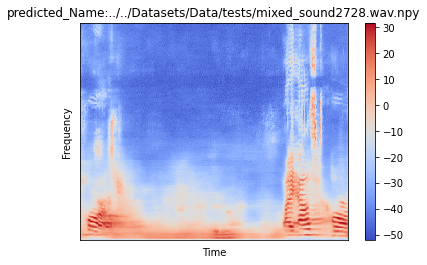

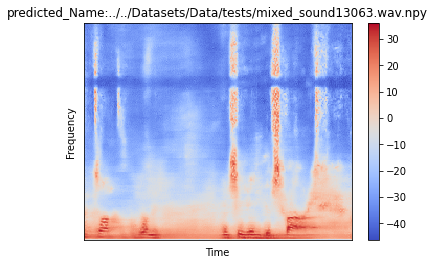

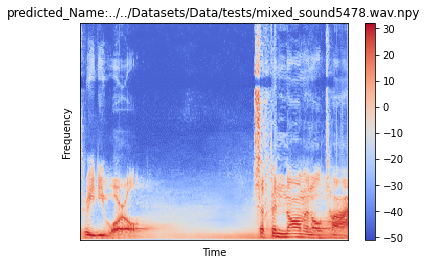

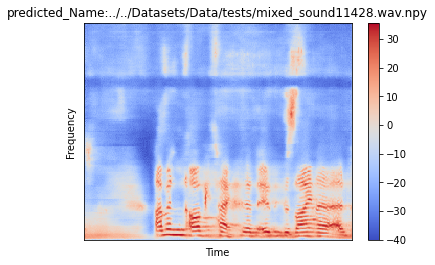

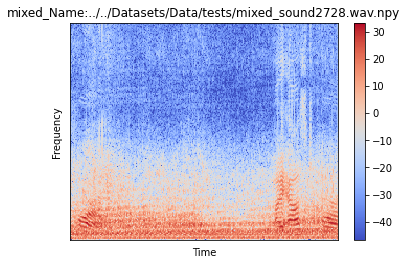

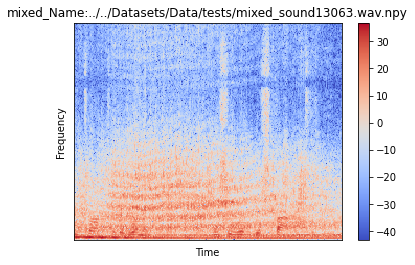

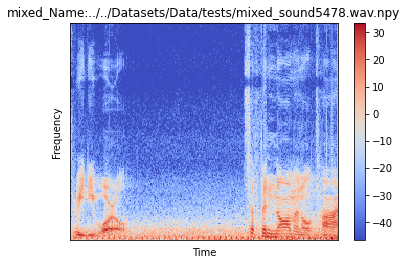

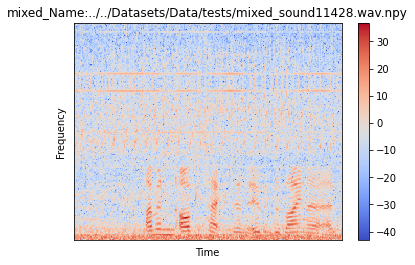

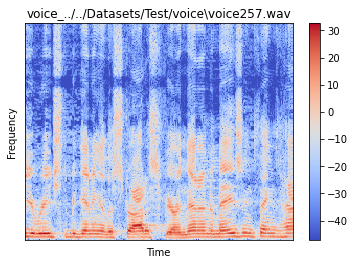

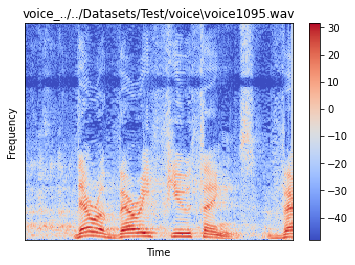

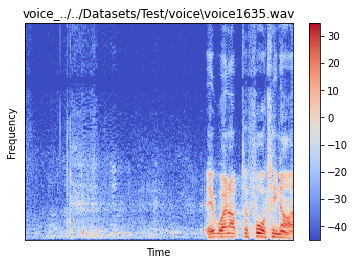

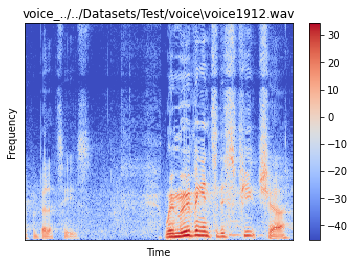

In [8]:
new_signals, predicted_path = convert_spectrograms_to_audio(
    signals, sampled_min_max_values,False,file_path )

original_signals, mixed_path = convert_spectrograms_to_audio(
    sampled_specs, sampled_min_max_values,True, file_path)

real_signals, real_path=spectrograms_of_voice(voice_paths)

In [ ]:
for i in range(len(predicted_path)):
    predicted_path[i]=predicted_path[i].split("d")[-1].split(".")[0]
for i in range(len(mixed_path)):
    mixed_path[i]=mixed_path[i].split("d")[-1].split(".")[0]
for i in range(len(real_path)):
    real_path[i]=real_path[i].split("e")[-1].split(".")[0]

In [46]:
save_signals(new_signals, SAVE_DIR_GENERATED, predicted_path, "predicted_")
save_signals(original_signals, SAVE_DIR_ORIGINAL, mixed_path, "mixed_")
save_signals(real_signals, SAVE_DIR_REAL, real_path, "real_")

## Métricas de los audios conseguidos

### MSE

In [ ]:
aircrafts=[]
lluvia=[]
trafico=[]
viento=[]
for i in tqdm(range(df_data.shape[0])):
    if(i<df_data.shape[0]/4-1):
        aircrafts.append(mean_squared_error(df_data.data[i], df_data.noise_original[i],squared=True))
    elif(i>=df_data.shape[0]/4-1 and i<df_data.shape[0]/4+499-1):
        lluvia.append(mean_squared_error(df_data.data[i], df_data.noise_original[i],squared=True))
    elif(i>=df_data.shape[0]/4+499-1 and i<df_data.shape[0]/4+499*2-1):
        trafico.append(mean_squared_error(df_data.data[i], df_data.noise_original[i],squared=True))
    else:
        viento.append(mean_squared_error(df_data.data[i], df_data.noise_original[i],squared=True))

In [ ]:

df=pd.DataFrame()
df.insert(0,"aircrafts_mean",[mean(aircrafts)])
df.insert(1,"aircrafts_desviacion",[desviacion(aircrafts)])

df.insert(2,"lluvia_mean",[mean(lluvia)])
df.insert(3,"lluvia_desviacion",[desviacion(lluvia)])

df.insert(4,"trafico_mean",[mean(trafico)])
df.insert(5,"trafico_desviacion",[desviacion(trafico)])

df.insert(6,"viento_mean",[mean(viento)])
df.insert(7,"viento_desviacion",[desviacion(viento)])